In [1]:
import numpy as np 

from astropy.table import Table
from astropy import units as u 
from astropy.nddata import CCDData, Cutout2D
from astropy.stats import sigma_clipped_stats, sigma_clip

In [2]:
from petrofit.utils import plot_target 
from petrofit.photometry import radial_elliptical_aperture, radial_elliptical_annulus

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['image.origin'] = 'lower'


In [4]:
import ipywidgets as widgets
from IPython.display import display

# Read in catalog 

In [5]:
catalog_filename = "hlsp_clash_hst_macs1423_v1_drz_petrosian_redshift_kcorrected_lcbg_catalog.csv"

In [6]:
lcbg_catalog = Table.read(catalog_filename)
lcbg_catalog.sort('z')

lcbg_catalog.sort(keys='z')

# Load Image

In [7]:
current_filter =  "f125w"
input_data_path ='https://archive.stsci.edu/pub/hlsp/clash/macs1423/data/hst/scale_65mas/hlsp_clash_hst_wfc3ir_macs1423_f160w_v1_drz.fits'

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
        Incon

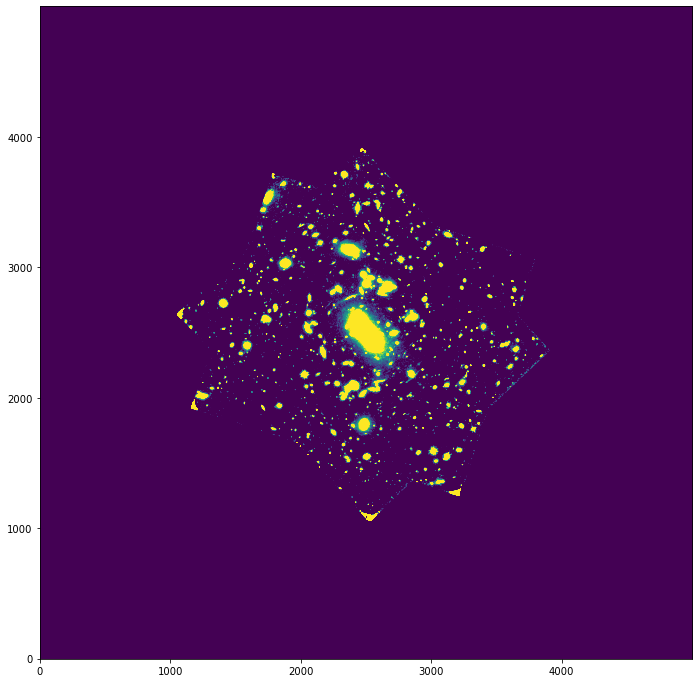

In [8]:
# Load data and vitals
# ---------------------
data = CCDData.read(input_data_path, cache=True)

plt.imshow(data, vmin=0, vmax=data.data.mean()*10)

0.004616818


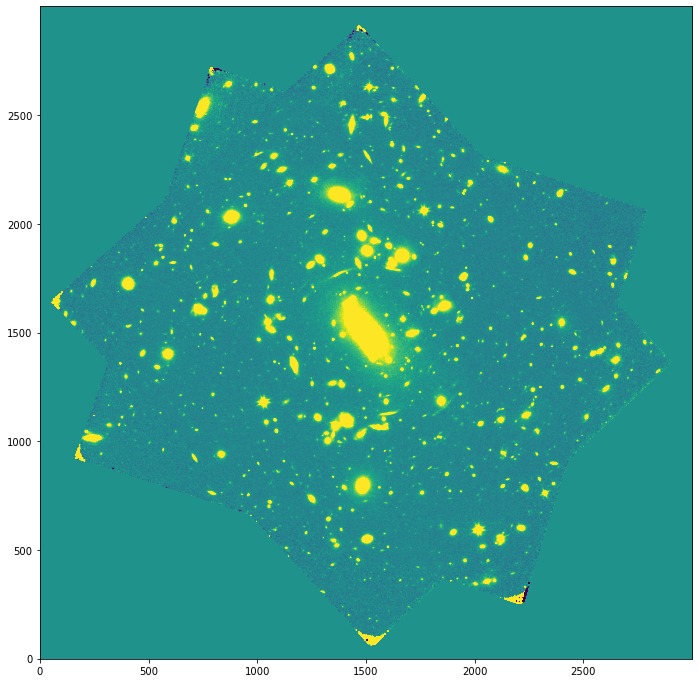

In [9]:
# Cutout Image
# -------------

# Select and crop image:

# Center of cluster:
cx, cy = [int(np.round(i)) for i in data.wcs.world_to_pixel_values(data.header["RA_TARG"], data.header["DEC_TARG"])]
size = 3000

image = Cutout2D(data, (cx, cy), size, copy=True)

# Compute image stats
image_min = image.data.min()
image_max = image.data.max()
image_mean = image.data.mean()
image_sigma = image.data.std()
image_3_sigma = image_sigma * 3.
image_8_sigma = image_sigma * 8.

image_clipped_mean, image_clipped_median, image_clipped_std = sigma_clipped_stats(image.data, sigma=3.0)

# Subtract Noise
image.data  -= image_clipped_mean

# Set min and max values for all plots
vmin = -10 * image_clipped_std
vmax = +10 * image_clipped_std

plt.imshow(image.data, vmin=vmin, vmax=vmax)

print(image_mean)

In [10]:
vmin = 0

In [11]:
# Test photometry function
def slider(x, v):
    vmin = 0#-v * image_clipped_std
    vmax = +v * image_clipped_std
    
    row = lcbg_catalog[x]
    
    obj_e = 1#row['elongation']
    obj_theta = 0#np.deg2rad(row['orientation'])
    
    ra = row['ra']
    dec = row['dec']

    position = [float(i) for i in image.wcs.wcs_world2pix(ra, dec, 0)]
    
    fig, ax = plt.subplots(1, 2, figsize=[16,8])
    plt.sca(ax[0])
    
    plot_target(position, image.data, 200, vmin=vmin, vmax=vmax)
    
    '''
    aperture = radial_elliptical_aperture(position, row['r_total_flux'], e=obj_e, theta=obj_theta)
    aperture.plot(plt.gca(), color='r', label='R Total')
    aperture = radial_elliptical_aperture(position, row['r_half_light'], e=obj_e, theta=obj_theta)
    aperture.plot(plt.gca(), color='r', linestyle="-", label='R Half Light')
    aperture = radial_elliptical_aperture(position, row['r20'], e=obj_e, theta=obj_theta)
    aperture.plot(plt.gca(), color='r', linestyle=':', label='R_20')
    aperture = radial_elliptical_aperture(position, row['r80'], e=obj_e, theta=obj_theta)
    aperture.plot(plt.gca(), color='r', linestyle=':', label='R_80')
    
    plt.legend()
    '''


    plt.sca(ax[1])
    
    plt.imshow(image.data, vmin=vmin, vmax=vmax, origin='lower')
    aperture = radial_elliptical_aperture(position, 50,elong=obj_e, theta=obj_theta)
    aperture.plot(plt.gca(), color='r', label='R Total')
    
    plt.show()
    
    display(row)


    
widgets.interact(slider, 
                 x=widgets.BoundedIntText(min=0, max=len(lcbg_catalog)-1), 
                 v=widgets.BoundedIntText(5, min=1, max=1000, step=5));

interactive(children=(BoundedIntText(value=0, description='x', max=2), BoundedIntText(value=5, description='v'…

In [12]:
lcbg_catalog

id,ra,dec,z,z_quality,surface_brightness,r_half_light_arcsec,m_u,m_b,m_v,m_m_total_f105w,m_m_total_f125w,m_m_total_f140w,m_m_total_f160w,m_m_total_f606w,m_m_total_f814w,M_u,M_b,M_v,M_m_total_f105w,M_m_total_f125w,M_m_total_f140w,M_m_total_f160w,M_m_total_f606w,M_m_total_f814w,kcorrect_constant_0,kcorrect_constant_1,kcorrect_constant_2,kcorrect_constant_3,kcorrect_constant_4,kcorrect_constant_5
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
72,215.93512403962623,24.065615995341386,0.6475,2.0,20.536723137603026,0.5580716143228783,21.6999454498291,21.976078033447266,21.567420959472656,20.975765228271484,20.921886444091797,20.882984161376953,20.827539443969727,21.453834533691406,21.221088409423828,-21.25574386952679,-20.979611285908625,-21.388268359883234,-21.979924091084406,-22.033802875264094,-22.072705157978938,-22.128149875386164,-21.501854785664484,-21.734600909932063,0.6474999785423279,1.4522876824740738e-11,2.5059943009608787e-10,4.9692467030126863e-08,2.904482414578524e-07,9.128114930589959e-12
193,215.9458217222659,24.074211067123326,0.9135,2.0,20.703956727233162,0.40308061612323454,23.25152587890625,23.499832153320312,23.19261360168457,23.023757934570312,23.05368423461914,23.076303482055664,23.096981048583984,23.149263381958008,23.010242462158203,-20.628043364643013,-20.37973709022895,-20.686955641864692,-20.85581130897895,-20.825885008930122,-20.8032657614936,-20.782588194965278,-20.730305861591255,-20.86932678139106,0.9135000109672546,9.257702620635433e-31,8.832093585132983e-13,4.637715544930643e-09,1.106606682273049e-25,1.0936154204443937e-08
166,215.97085742794283,24.072331850906718,0.93,1.0,20.322167243561452,0.1647689537907622,24.66333770751953,25.09791374206543,24.83670425415039,24.32245445251465,24.209388732910156,24.143312454223633,24.069046020507812,24.749866485595703,24.569625854492188,-19.26457788107578,-18.830001846529882,-19.09121133444492,-19.605461136080663,-19.718526855685155,-19.78460313437168,-19.8588695680875,-19.17804910299961,-19.358289734103124,0.9300000071525574,4.572052514362213e-09,1.495252185956808e-11,1.82841231044506e-09,4.393816323397947e-17,1.0459119126338123e-09


In [24]:
(0.9834765130085065*u.arcsec*2.1).to('rad').value

1.0012860239684914e-05